<a href="https://colab.research.google.com/github/Offliners/OFF/blob/main/HW11/homework11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Arvin Liu (r09922071@ntu.edu.tw)

If there are any questions, please contact ntu-ml-2021spring-ta@googlegroups.com

# Readme

In homework 11, you will need to implement Domain Adversarial Training in Transfer Learning. As shown in the bottom left part of the figure.

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 

## Scenario and Why Domain Adversarial Training
Now we have labeled source data and unlabeled target data, where source data might be relavent to the target data. We now want to train a model with source data only and test it on target data.

What problem might occur if we do so? After we have learned Anomaly Detection, we now know that if we test the model with an abnormal data that have never appeared in source data, our trained model is likely to result in poor performance since it is not familiar with the abnormal data.

For example, we have a model that contains Feature Extractor and Classifier:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

When the model is trained with source data, the feature extractor 
will extract meaningful features since it is familiar with the distribution of it.It could be seen in the following figure that the blue dots, which is the distribution of source data, has already been clustered into different clusters. Therefore, the Classifier can predict the label based on these clusters.

However, when test on the target data, the Feature Extractor will not be able to extract meaningful features that follow the distribution of the source feature distribution, which result in the classifier learned for the source domain will not be able to apply to the target domain.


## Domain Adversarial Training of Nerural Networks (DaNN)

Based on the above problems, DaNN approaches build mappings between the source (training-time) and the target (test-time) domains, so that the classifier learned for the source domain can also be applied to the target domain, when composed with the learned mapping between domains.

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

In DaNN, the authors added a Domain Classifier, which is a deep discriminatively-trained classifeir in the training framework to distinguish the data from different domain by the features extracted by the feature extractor. As the training progresses, the approach promotes a domain classifier that discriminates between the source and the target domains and a feature extractor that can extractor features that are discriminative for the main learning task on the source domain and indiscriminate with respect to the shift between the domains. 


The feature extractor are likely to outperform the domain classifier as its input are generated by the feature extractor and that the task of domain classification and label classification are not conflict.

This method leads to the emergence of features that are domain-invariant and on the same feature distribution.

In [1]:
!nvidia-smi

Tue May 25 17:23:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data Introduce

Our task contains source data: real photos, and target data: hand-drawn graffiti.

We are going to train the model with the photos and the labels, and try to predict what the labels are for hand-drawn graffiti.

The data could be downloaded [here](https://drive.google.com/open?id=12-07DSquGdzN3JBHBChN4nMo3i8BqTiL). The code below is for data downloading and visualization.

Note that: **The source and target data are all balanced data, you can make use of this information.**

In [3]:
# Download dataset
!gdown --id '1P4fGNb9JhJj8W0DA_Qrp7mbrRHfF5U_f' --output real_or_drawing.zip
# Unzip the files
!unzip real_or_drawing.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_or_drawing/train_data/0/106.bmp  
  inflating: real_or_drawing/train_data/0/107.bmp  
  inflating: real_or_drawing/train_data/0/108.bmp  
  inflating: real_or_drawing/train_data/0/109.bmp  
  inflating: real_or_drawing/train_data/0/11.bmp  
  inflating: real_or_drawing/train_data/0/110.bmp  
  inflating: real_or_drawing/train_data/0/111.bmp  
  inflating: real_or_drawing/train_data/0/112.bmp  
  inflating: real_or_drawing/train_data/0/113.bmp  
  inflating: real_or_drawing/train_data/0/114.bmp  
  inflating: real_or_drawing/train_data/0/115.bmp  
  inflating: real_or_drawing/train_data/0/116.bmp  
  inflating: real_or_drawing/train_data/0/117.bmp  
  inflating: real_or_drawing/train_data/0/118.bmp  
  inflating: real_or_drawing/train_data/0/119.bmp  
  inflating: real_or_drawing/train_data/0/12.bmp  
  inflating: real_or_drawing/train_data/0/120.bmp  
  inflating: real_or_drawing/train_data/0/121.bmp  
  inflating: re

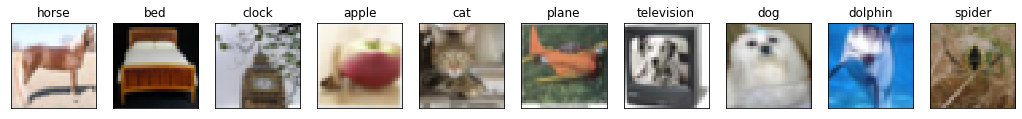

In [4]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

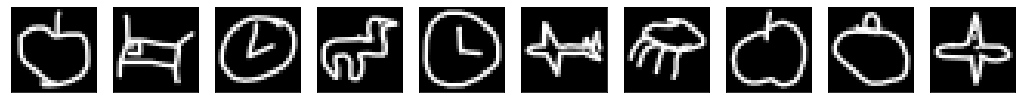

In [5]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

When we graffiti, we usually draw the outline only, therefore we can perform edge detection processing on the source data to make it more similar to the target data.


## Canny Edge Detection
The implementation of Canny Edge Detection is as follow.
The algorithm will not be describe thoroughly here.  If you are interested, please refer to the wiki or [here](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19).

We only need two parameters to implement Canny Edge Detection with CV2:  `low_threshold` and `high_threshold`.

```cv2.Canny(image, low_threshold, high_threshold)```

Simply put, when the edge value exceeds the high_threshold, we determine it as an edge. If the edge value is only above low_threshold, we will then determine whether it is an edge or not.

Let's implement it on the source data.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


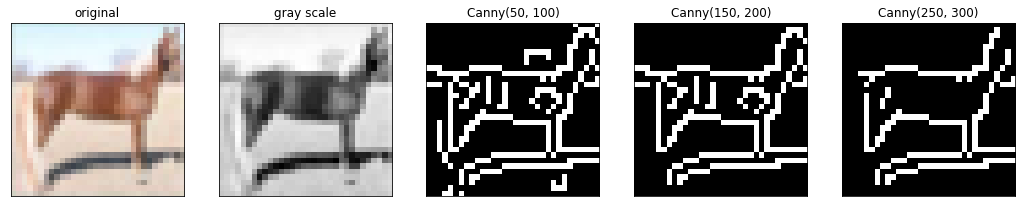

In [6]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')
  

# Data Process
 
 
The data is suitible for `torchvision.ImageFolder`. You can create a dataset with `torchvision.ImageFolder`. Details for image augmentation please refer to the comments in the following codes.

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
 
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from time import time
 
source_transform = transforms.Compose([
    transforms.Grayscale() ,
    transforms.Lambda(lambda x : cv2.Canny(np.array(x) , 250 , 300)) ,
    transforms.ToPILImage() ,
    transforms.RandomAffine(10 , translate = (0.1 , 0.1) , scale = (0.9 , 1.1)) ,
    transforms.RandomHorizontalFlip() ,
    transforms.ToTensor()
])

target_transform = transforms.Compose([
    transforms.Grayscale() ,
    transforms.Resize((32 , 32)) ,
    transforms.RandomAffine(10 , translate = (0.1 , 0.1) , scale = (0.9 , 1.1)) ,
    transforms.RandomHorizontalFlip() ,
    transforms.ToTensor()
])

# test_transform = transforms.Compose([
#     transforms.Grayscale() ,
# 	  transforms.Resize((32 , 32)) ,
# 		transforms.ToTensor()
# ])

source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)
# test_dataset = ImageFolder('real_or_drawing/test_data', transform=test_transform)

batch_size = 128
source_dataloader = DataLoader(source_dataset, batch_size=batch_size, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=batch_size * 2, shuffle=False)

# Model

Feature Extractor: Classic VGG-like architecture

Label Predictor / Domain Classifier: Linear models.

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator , self).__init__()
        self.conv1 = nn.Conv2d(1 , 64 , kernel_size = (5 , 5) , stride = (1 , 1) , padding = (2 , 2))
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64 , 64 , kernel_size = (5 , 5) , stride = (1 , 1) , padding = (2 , 2))
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64 , 128 , kernel_size = (5 , 5) , stride = (1 , 1) , padding = (2 , 2))
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(8192 , 3072)
        self.bn4 = nn.BatchNorm1d(3072)

    def forward(self , x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))) , stride = (2 , 2) , kernel_size = (3 , 3) , padding = (1 , 1))
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))) , stride = (2 , 2) , kernel_size = (3 , 3) , padding = (1 , 1))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0) , 8192)
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.dropout(x , training = self.training)
        return x

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier , self).__init__()
        self.fc1 = nn.Linear(3072 , 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.fc2 = nn.Linear(2048 , 10)

    def set_lambda(self , lambd):
        self.lambd = lambd

    def forward(self , x , reverse = False):
        if (reverse):
          x = grad_reverse(x , self.lambd)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        return x

# Pre-processing

Here we use Adam as our optimizor.

In [9]:
from torch.optim.lr_scheduler import StepLR

feature_generator = Generator().cuda()
classifier1 = Classifier().cuda()
classifier2 = Classifier().cuda()

classifier1_criterion = nn.CrossEntropyLoss()
classifier2_criterion = nn.CrossEntropyLoss()

learning_rate = 1e-5
weight_decay = 1e-4
optimizer_F = optim.Adam(feature_generator.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_classifier1 = optim.Adam(classifier1.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_classifier2 = optim.Adam(classifier2.parameters(), lr=learning_rate, weight_decay=weight_decay)

# scheduler1 = StepLR(optimizer_classifier1, step_size=200)
# scheduler2 = StepLR(optimizer_classifier2, step_size=200)

In [10]:
def print_progress(epoch, total_epoch, batch, total_batch, loss, loss1, loss2, total_time = None):
    if (batch < total_batch):
        length = int(50 * batch / total_batch)
        bar = length * '=' + '>' + (49 - length) * ' '
        print('\repoch {}/{} [{}]'.format(epoch, total_epoch, bar), end = '')
    else:
        bar = 50 * '='
        print('\repoch {}/{} [{}] loss {:.5f} loss_1 {:.5f} loss_2 {:.5f} ({}s)'.format(epoch, total_epoch, bar, loss, loss1, loss2, total_time))
    return

def discrepancy(output_1 , output_2):
	  return torch.mean(torch.abs(F.softmax(output_1 , dim = 1) - F.softmax(output_2 , dim = 1)))

# Start Training


## DaNN Implementation

In the original paper, Gradient Reversal Layer is used.
Feature Extractor, Label Predictor, and Domain Classifier are all trained at the same time. In this code, we train Domain Classifier first, and then train our Feature Extractor (same concept as Generator and Discriminator training process in GAN).

## Reminder
* Lambda, which controls the domain adversarial loss, is adaptive in the original paper. You can refer to [the original work](https://arxiv.org/pdf/1505.07818.pdf) . Here lambda is set to 0.1.
* We do not have the label to target data, you can only evaluate your model by uploading your result to kaggle.:)

In [12]:
epoch = 3000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

feature_generator.load_state_dict(torch.load('./gdrive/MyDrive/HW11/generator_2500.pkl' , map_location = device))
classifier1.load_state_dict(torch.load('./gdrive/MyDrive/HW11/classifier_1_2500.pkl' , map_location = device))
classifier2.load_state_dict(torch.load('./gdrive/MyDrive/HW11/classifier_2_2500.pkl' , map_location = device))

for i in range(2500, epoch):
    feature_generator.train()
    classifier1.train()
    classifier2.train()
    number_of_batch = min(len(source_dataloader) , len(target_dataloader))

    start = time()
    for (j , ((source_data , source_label) , (target_data , _))) in enumerate(zip(source_dataloader , target_dataloader)):
        (source_data , source_label , target_data) = (source_data.to(device) , source_label.to(device) , target_data.to(device))
        # Step 1
        optimizer_F.zero_grad()
        optimizer_classifier1.zero_grad()
        optimizer_classifier2.zero_grad()
        feature = feature_generator(source_data)
        output_1 = classifier1(feature)
        output_2 = classifier2(feature)
        loss = F.cross_entropy(output_1 , source_label) + F.cross_entropy(output_2 , source_label)
        loss.backward()
        optimizer_F.step()
        optimizer_classifier1.step()
        optimizer_classifier2.step()
        # Step 2
        optimizer_F.zero_grad()
        optimizer_classifier1.zero_grad()
        optimizer_classifier2.zero_grad()
        feature = feature_generator(source_data)
        output_1 = classifier1(feature)
        output_2 = classifier2(feature)
        loss_1 = F.cross_entropy(output_1 , source_label) + F.cross_entropy(output_2 , source_label)
        feature = feature_generator(target_data)
        output_1 = classifier1(feature)
        output_2 = classifier2(feature)
        loss_2 = discrepancy(output_1 , output_2)
        loss = loss_1 - loss_2
        loss.backward()
        optimizer_classifier1.step()
        optimizer_classifier2.step()
        # Step 3
        for k in range(4):
            feature = feature_generator(target_data)
            output_1 = classifier1(feature)
            output_2 = classifier2(feature)
            loss = discrepancy(output_1 , output_2)
            loss.backward()
            optimizer_F.step()
        end = time()
        print_progress(i + 1, epoch, j + 1, number_of_batch, loss, loss_1, loss_2, int(end - start))
    
    # scheduler1.step()
    # scheduler2.step()
    if (i + 1) % 50 == 0:
        torch.save(feature_generator.state_dict() , f'./gdrive/MyDrive/HW11/generator_{i+1}.pkl')
        torch.save(classifier1.state_dict() , f'./gdrive/MyDrive/HW11/classifier_1_{i+1}.pkl')
        torch.save(classifier2.state_dict() , f'./gdrive/MyDrive/HW11/classifier_2_{i+1}.pkl')

epoch 2501/3000 [==================================================] loss 0.00806 loss_1 0.30696 loss_2 0.00868 (8s)
epoch 2502/3000 [==================================================] loss 0.00966 loss_1 0.93744 loss_2 0.00941 (8s)
epoch 2503/3000 [==================================================] loss 0.00704 loss_1 0.20970 loss_2 0.00641 (8s)
epoch 2504/3000 [==================================================] loss 0.00494 loss_1 0.01126 loss_2 0.00582 (8s)
epoch 2505/3000 [==================================================] loss 0.01026 loss_1 0.02385 loss_2 0.00733 (8s)
epoch 2506/3000 [==================================================] loss 0.00651 loss_1 0.01889 loss_2 0.00766 (8s)
epoch 2507/3000 [==================================================] loss 0.00735 loss_1 0.28285 loss_2 0.00755 (8s)
epoch 2508/3000 [==================================================] loss 0.00750 loss_1 0.01972 loss_2 0.00471 (8s)
epoch 2509/3000 [===============================================

# Inference

We use pandas to generate our csv file.

BTW, the performance of the model trained for 200 epoches might be unstable. You can train for more epoches for a more stable performance.

In [13]:
feature_generator.eval()
classifier1.eval()
classifier2.eval()
result = []
with torch.no_grad():
    for (data , _) in test_dataloader:
        data = data.to(device)
        feature = feature_generator(data)
        output_1 = classifier1(feature)
        output_2 = classifier2(feature)
        output = (output_1 + output_2) / 2
        (_ , index) = torch.max(output , dim = 1)
        result.append(index.cpu().detach().numpy())
    result = np.concatenate(result , axis = 0)

import pandas as pd

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)

In [14]:
from google.colab import files
files.download("DaNN_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

If there are any problem related to Domain Adaptation, please email to b05902127@ntu.edu.tw / ntu-ml-2020spring-ta@googlegroups.com。

The Q&A section might be updated to here if I have time.


# **Reference**

Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW11/HW11.ipynb)